# Creating my own dataset from Google Images & Training a CNN 

*by: Mehdi Amine. Inspired by [Francisco Ingham and Jeremy Howard](https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson2-download.ipynb)*

### Project Outline
**Step 1 - Creating a dataset:**

- [x] Google a set of monuments
    - [x] Giza pyramids
    - [x] Notre Dame cathedral
    - [x] Dome of the rock
    - [x] Pisa tower
    - [x] Big Ben    
- [x] Download the urls of each monument images returned from Google as csv files
    - [x] use this Javascript code on the browser console:
    ```javascript
    urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
    window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
    ```
- [x] Create 5 directories to store the 5 csv files
- [x] Iterate through the urls on each csv file and download the images in their corresponding directory
- [x] Delete images that couldn't be opened

**Step 2 - Data Inspection:**
- [x] Create an ImageDataBunch
    - [x] Use fromFolder() to define the dataset's labels from the directories' names
    - [x] Use 20% of the dataset for validation
    - [x] Normalize images using imagenet_stats
    - [x] Display a batch of images

**Step 3 - Model Training:**
- [x] Create an ImageDataBunch
    - [x] Use ResNet model for CNN ([ResNet Benchmark](https://dawn.cs.stanford.edu/benchmark/#imagenet)) 
    - [x] Unfreeze the model and optimize learning rate
    
**Step 4 - Interpretation:**
- [x] Plot confusion matrix
- [x] Plot top losses

**Step 5 - Putting Model in Production:**
- [x] Export model as 'export.pkl' file
- [ ] Create a route for an HTTP GET request

## Creating a Dataset

In [75]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [74]:
from fastai.vision import *
from fastai.metrics import error_rate

In [26]:
# Creating directories to store csv files containing image urls
path = Path('data/monuments')
folders = ['big_ben', 'giza_pyramid', 'jerusalem_dome', 'notre_dame', 'pisa_tower']
files = ['big_ben_urls.csv', 'giza_pyramid_urls.csv', 'jerusalem_dome_urls.csv', 'notre_dame_urls.csv', 'pisa_tower_urls.csv']

for folder in folders:
    dest = path/folder
    dest.mkdir(parents=True, exist_ok=True)

# Downloading images in their appropriate directory
for folder, file in zip(folders, files):
    download_images(path/folder/file, path/folder, max_pics=200)

In [36]:
# Deleting images that couldn't be opened
for folder in folders:
    print(folder)
    verify_images(path/folder, delete=True, max_size=500)

big_ben


cannot identify image file <_io.BufferedReader name='data/monuments/big_ben/00000021.jpg'>
cannot identify image file <_io.BufferedReader name='data/monuments/big_ben/00000061.jpg'>
cannot identify image file <_io.BufferedReader name='data/monuments/big_ben/00000044.jpg'>


/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py:1005: UserWarning: Couldn't allocate palette entry for transparency
  warnings.warn("Couldn't allocate palette entry " +


int() argument must be a string, a bytes-like object or a number, not 'tuple'
giza_pyramid


cannot identify image file <_io.BufferedReader name='data/monuments/giza_pyramid/00000016.jpg'>
cannot identify image file <_io.BufferedReader name='data/monuments/giza_pyramid/00000084.jpg'>
cannot identify image file <_io.BufferedReader name='data/monuments/giza_pyramid/00000076.jpg'>
jerusalem_dome


cannot identify image file <_io.BufferedReader name='data/monuments/jerusalem_dome/00000067.jpg'>
cannot identify image file <_io.BufferedReader name='data/monuments/jerusalem_dome/00000027.jpg'>
notre_dame


cannot identify image file <_io.BufferedReader name='data/monuments/notre_dame/00000073.jpg'>
cannot identify image file <_io.BufferedReader name='data/monuments/notre_dame/00000080.jpg'>
cannot identify image file <_io.BufferedReader name='data/monuments/notre_dame/00000016.jpg'>
cannot identify image file <_io.BufferedReader name='data/monuments/notre_dame/00000010.jpg'>
cannot identify image file <_io.BufferedReader name='data/monuments/notre_dame/00000001.jpg'>
pisa_tower


cannot identify image file <_io.BufferedReader name='data/monuments/pisa_tower/00000015.jpg'>


## Data Inspection

In [37]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [38]:
data.classes

['big_ben', 'giza_pyramid', 'jerusalem_dome', 'notre_dame', 'pisa_tower']

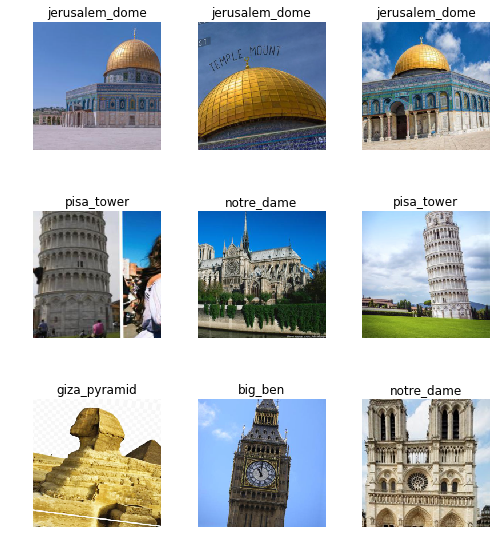

In [41]:
data.show_batch(rows=3, figsize=(7,8))

In [43]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['big_ben', 'giza_pyramid', 'jerusalem_dome', 'notre_dame', 'pisa_tower'],
 5,
 385,
 96)

## Model Training

In [44]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/jupyter/.torch/models/resnet34-333f7ec4.pth
87306240it [00:09, 9649911.88it/s] 


In [45]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.631392,0.694266,0.166667,00:06
1,0.964930,0.124968,0.020833,00:03
2,0.655232,0.076141,0.031250,00:03
3,0.496950,0.071088,0.020833,00:03


In [46]:
learn.save('stage-1')

In [47]:
learn.unfreeze()

In [48]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


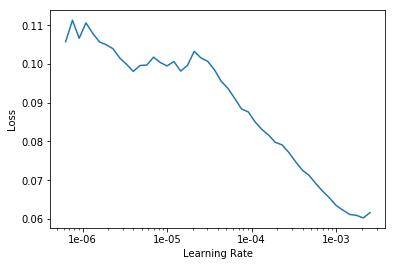

In [49]:
learn.recorder.plot()

In [50]:
learn.fit_one_cycle(2, max_lr=slice(1e-4,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.113521,0.049784,0.010417,00:04
1,0.080344,0.020782,0.010417,00:04


In [51]:
learn.save('stage-2')

## Interpretation

### Model Stage-1

In [65]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (385 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
jerusalem_dome,jerusalem_dome,jerusalem_dome,jerusalem_dome,jerusalem_dome
Path: data/monuments;

Valid: LabelList (96 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
jerusalem_dome,pisa_tower,pisa_tower,notre_dame,pisa_tower
Path: data/monuments;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     

In [66]:
interp = ClassificationInterpretation.from_learner(learn)

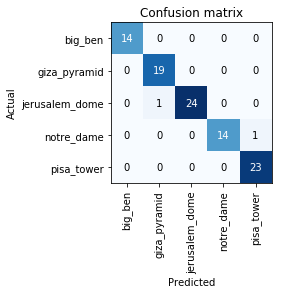

In [67]:
interp.plot_confusion_matrix()

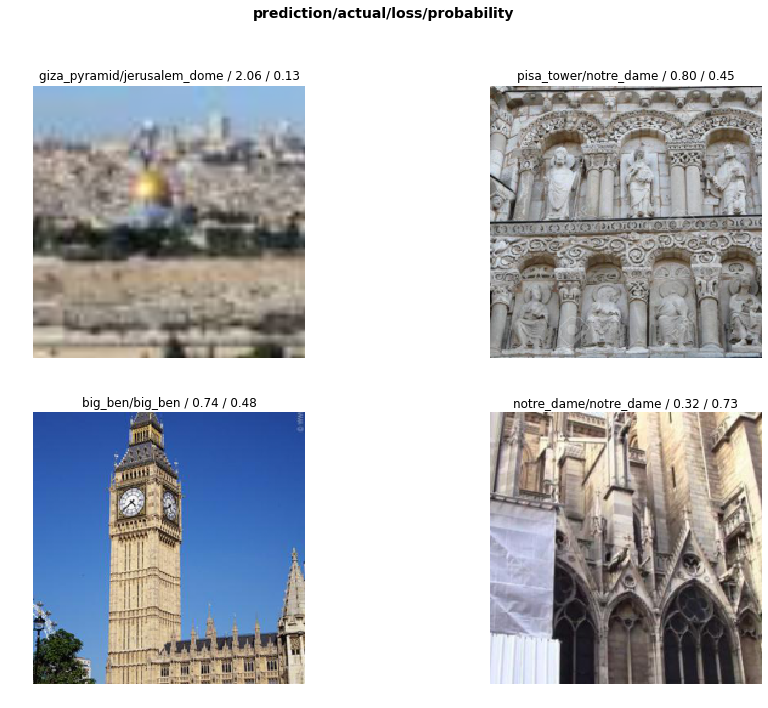

In [71]:
interp.plot_top_losses(4, figsize=(15,11), heatmap=False)

### Model Stage-2

In [76]:
learn.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (385 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
jerusalem_dome,jerusalem_dome,jerusalem_dome,jerusalem_dome,jerusalem_dome
Path: data/monuments;

Valid: LabelList (96 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
jerusalem_dome,pisa_tower,pisa_tower,notre_dame,pisa_tower
Path: data/monuments;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     

In [77]:
interp = ClassificationInterpretation.from_learner(learn)

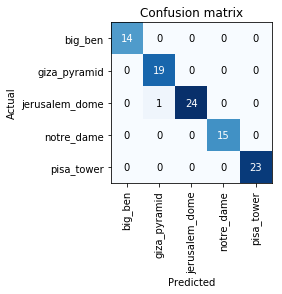

In [78]:
interp.plot_confusion_matrix()

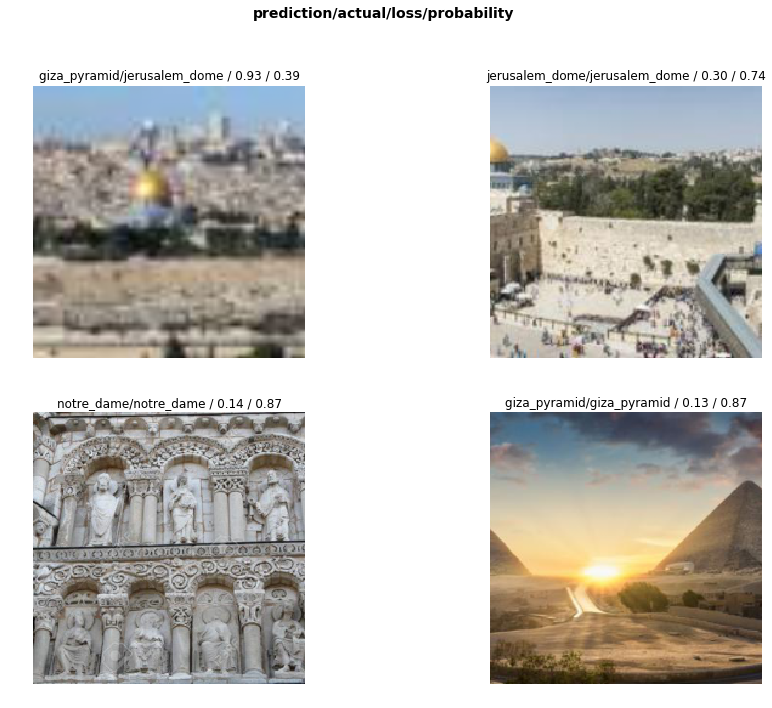

In [79]:
interp.plot_top_losses(4,figsize=(15,11), heatmap=False)

## Putting Model in Production

In [80]:
learn.export()

In [81]:
defaults.device = torch.device('cpu')

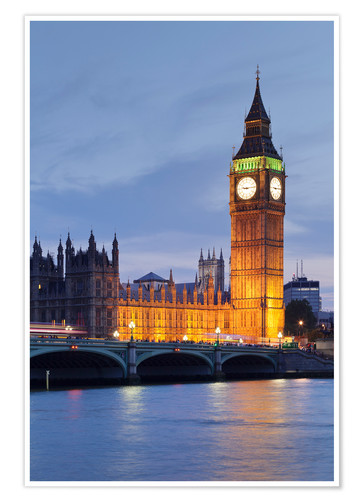

In [84]:
img = open_image(path/'big_ben'/'00000001.jpg'); img

In [85]:
learn = load_learner(path)

In [86]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category big_ben